In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from fastcore.xtras import load_pickle
from guacamol.utils.chemistry import is_valid

from gptchem.data import get_photoswitch_data
from gptchem.evaluator import evaluate_generated_smiles, evaluate_photoswitch_smiles_pred
from gptchem.settings import ONE_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_WIDTH_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])

import matplotx

%matplotlib inline

In [32]:
from rdkit import Chem

In [33]:
all_res = glob("out/**/*.pkl")

In [34]:
res = load_pickle(all_res[0])

In [35]:
from collections import defaultdict

In [36]:
def contains_azo(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # check if there is a N#N bond
    smarts = "[NX2]=N"
    return mol.HasSubstructMatch(Chem.MolFromSmarts(smarts))

In [37]:
compiled_res = []
generated_smiles = set()
generated_smiles_w_azos = set()

generated_smiles_w_azos_at_temp = defaultdict(set)
generated_smiles_at_temp = defaultdict(set)

for res_path in all_res:
    res = load_pickle(res_path)
    for temp_res in res["res_at_temp"]:

        metrics = {
            "noise_level": res["noise_level"],
            "temp": temp_res["temperature"],
            "frac_valid": temp_res["frac_valid"],
            "frac_unique": temp_res["frac_unique"],
            "frac_smiles_in_train": temp_res["frac_smiles_in_train"],
            "frac_smiles_in_pubchem": temp_res["frac_smiles_in_pubchem"],
            "kld": temp_res["kld"],
            "frechet_d": temp_res["frechet_d"],
            "frechet_score": temp_res["frechet_score"],
            "frac_contains_azo": sum([contains_azo(s) for s in temp_res["valid_smiles"]])
            / len(temp_res["valid_smiles"]),
        }

        generated_smiles.update([s for s in temp_res["generated_smiles"] if is_valid(s)])
        v_w_azo = [s for s in temp_res["generated_smiles"] if is_valid(s) and contains_azo(s)]
        generated_smiles_w_azos.update(v_w_azo)
        generated_smiles_w_azos_at_temp[temp_res["temperature"]].update(v_w_azo)

        v = [s for s in temp_res["generated_smiles"] if is_valid(s)]
        generated_smiles_at_temp[temp_res["temperature"]].update(v)

        for me, v in temp_res["e_pi_pi_star_metrics"].items():
            metrics["e_pi_pi_star_" + me] = v

        for me, v in temp_res["z_pi_pi_star_metrics"].items():
            metrics["z_pi_pi_star_" + me] = v
        compiled_res.append(metrics)

In [38]:
contains_azo(list(generated_smiles)[5])

True

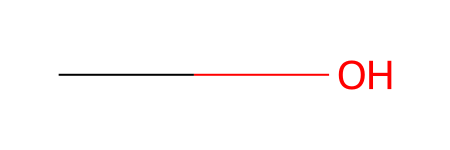

In [39]:
Chem.MolFromSmiles(list(generated_smiles)[0])

In [40]:
df = pd.DataFrame(compiled_res)

In [41]:
grouped = df.groupby(["temp"]).agg(["mean", "std"])

In [42]:
grouped

noise_level            frac_valid          frac_unique            \
            mean        std       mean      std        mean       std   
temp                                                                    
0.00        23.5  24.934915   0.866667  0.23094    0.488889  0.252396   
0.10        23.5  24.934915   1.000000  0.00000    0.466667  0.115470   
0.20        23.5  24.934915   1.000000  0.00000    0.733333  0.115470   
0.50        23.5  24.934915   1.000000  0.00000    0.933333  0.115470   
0.75        23.5  24.934915   1.000000  0.00000    0.933333  0.115470   
1.00        23.5  24.934915   0.800000  0.20000    0.916667  0.144338   
1.25        23.5  24.934915   0.333333  0.23094    0.888889  0.192450   
1.50        23.5  24.934915   0.200000  0.00000    1.000000  0.000000   
2.00        23.5  24.934915   0.200000  0.00000    1.000000  0.000000   

     frac_smiles_in_train      frac_smiles_in_pubchem       ...  \
                     mean  std                   mean  std  ...   
temp                                                        ...   
0.00                  0.0  0.0                    1.0  0.0  ...   
0.10                  0.0  0.0                    1.0  0.0  ...   
0.20                  0.0  0.0                    1.0  0.0  ...   
0.50                  0.0  0.0                    1.0  0.0  ...   
0.75                  0.0  0.0                    1.0  0.0  ...   
1.00                  0.0  0.0                    1.0  0.0  ...   
1.25                  0.0  0.0                    1.0  0.0  ...   
1.50                  0.0  0.0                    1.0  0.0  ...   
2.00                  0.0  0.0                    1.0  0.0  ...   

     z_pi_pi_star_r2            z_pi_pi_star_max_error             \
                mean        std                   mean        std   
temp                                                                
0.00       -0.036034   0.077899              36.250017   5.162991   
0.10       -0.202727   0.216587              54.893761  34.770121   
0.20       -0.215800   0.177668              55.882693  38.741758   
0.50       -0.575895   0.776242              58.256917  28.676637   
0.75       -0.569794   0.550532              60.242354  34.157551   
1.00       -9.063358  14.703244              48.321092  38.005154   
1.25       -0.747235        NaN              36.427621  53.666615   
1.50             NaN        NaN              24.622521  31.225456   
2.00             NaN        NaN              33.068983  28.265053   

     z_pi_pi_star_mean_absolute_error             \
                                 mean        std   
temp                                               
0.00                        20.672297  10.185561   
0.10                        24.827738  16.540900   
0.20                        26.212514  17.778324   
0.50                        27.292035  15.290360   
0.75                        26.921328  17.455671   
1.00                        25.795632  18.472242   
1.25                        19.724098  24.799052   
1.50                        24.622521  31.225456   
2.00                        33.068983  28.265053   

     z_pi_pi_star_mean_squared_error              z_pi_pi_star_rmse             
                                mean          std              mean        std  
temp                                                                            
0.00                      627.487141   459.935595         24.017284   8.716986  
0.10                     1142.721448  1295.092792         30.370571  18.180341  
0.20                     1256.123345  1513.734394         31.275355  20.419679  
0.50                     1225.971281  1149.844457         32.563526  15.760143  
0.75                     1359.996848  1429.882852         33.663337  18.443559  
1.00                     1202.276562  1483.563888         29.990928  21.312700  
1.25                     1252.474446  2107.455727         23.886635  31.982099  
1.50                     1256.287934  2093.412323         2

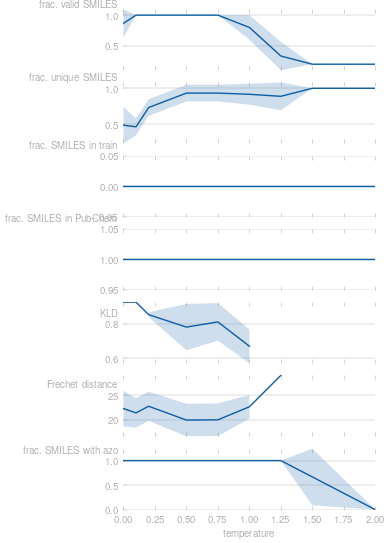

In [43]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(7, 1, sharex="all", figsize=(ONE_COL_WIDTH_INCH, 2 * ONE_COL_WIDTH_INCH))
    ax[0].plot(grouped.index, grouped["frac_valid"]["mean"], label="frac_valid")
    ax[0].fill_between(
        grouped.index,
        grouped["frac_valid"]["mean"] - grouped["frac_valid"]["std"],
        grouped["frac_valid"]["mean"] + grouped["frac_valid"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. valid SMILES", ax=ax[0])

    ax[1].plot(grouped.index, grouped["frac_unique"]["mean"], label="frac_unique")
    ax[1].fill_between(
        grouped.index,
        grouped["frac_unique"]["mean"] - grouped["frac_unique"]["std"],
        grouped["frac_unique"]["mean"] + grouped["frac_unique"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. unique SMILES", ax=ax[1])

    ax[2].plot(grouped.index, grouped["frac_smiles_in_train"]["mean"], label="frac_smiles_in_train")
    ax[2].fill_between(
        grouped.index,
        grouped["frac_smiles_in_train"]["mean"] - grouped["frac_smiles_in_train"]["std"],
        grouped["frac_smiles_in_train"]["mean"] + grouped["frac_smiles_in_train"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. SMILES in train", ax=ax[2])

    ax[3].plot(
        grouped.index, grouped["frac_smiles_in_pubchem"]["mean"], label="frac_smiles_in_pubchem"
    )
    ax[3].fill_between(
        grouped.index,
        grouped["frac_smiles_in_pubchem"]["mean"] - grouped["frac_smiles_in_pubchem"]["std"],
        grouped["frac_smiles_in_pubchem"]["mean"] + grouped["frac_smiles_in_pubchem"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. SMILES in PubChem", ax=ax[3])

    ax[4].plot(grouped.index, grouped["kld"]["mean"], label="kld")
    ax[4].fill_between(
        grouped.index,
        grouped["kld"]["mean"] - grouped["kld"]["std"],
        grouped["kld"]["mean"] + grouped["kld"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("KLD", ax=ax[4])

    ax[5].plot(grouped.index, grouped["frechet_d"]["mean"], label="frechet_d")
    ax[5].fill_between(
        grouped.index,
        grouped["frechet_d"]["mean"] - grouped["frechet_d"]["std"],
        grouped["frechet_d"]["mean"] + grouped["frechet_d"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("Frechet distance", ax=ax[5])

    ax[6].plot(grouped.index, grouped["frac_contains_azo"]["mean"], label="frechet_score")
    ax[6].fill_between(
        grouped.index,
        grouped["frac_contains_azo"]["mean"] - grouped["frac_contains_azo"]["std"],
        grouped["frac_contains_azo"]["mean"] + grouped["frac_contains_azo"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. SMILES with azo", ax=ax[6])

    ax[-1].set_xlabel("temperature", labelpad=4)

    fig.savefig("photoswitch_extrapolation_smiles_metrics.pdf", bbox_inches="tight")

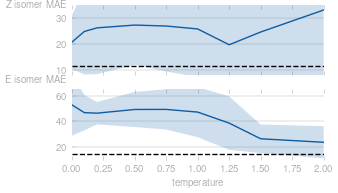

In [44]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(
        2, 1, sharex="all", figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH)
    )

    ax[0].plot(
        grouped.index,
        grouped["z_pi_pi_star_mean_absolute_error"]["mean"],
        label="e_pi_pi_star_metrics",
    )
    ax[0].fill_between(
        grouped.index,
        grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
        - grouped["z_pi_pi_star_mean_absolute_error"]["std"],
        grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
        + grouped["z_pi_pi_star_mean_absolute_error"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("Z isomer MAE", ax=ax[0])

    ax[0].hlines(11.616605626696359, 0, 2, color="k", linestyle="--")

    ax[0].set_ylim(8, 35)

    ax[1].plot(
        grouped.index,
        grouped["e_pi_pi_star_mean_absolute_error"]["mean"],
        label="e_pi_pi_star_metrics",
    )
    ax[1].fill_between(
        grouped.index,
        grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
        - grouped["e_pi_pi_star_mean_absolute_error"]["std"],
        grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
        + grouped["e_pi_pi_star_mean_absolute_error"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("E isomer MAE", ax=ax[1])

    ax[1].hlines(14.38998132190228, 0, 2, color="k", linestyle="--")

    ax[-1].set_xlabel("temperature", labelpad=4)
    ax[1].set_ylim(10, 65)
fig.savefig("extrapolation_photoswitch_constrain_matches.pdf", bbox_inches="tight")

## Visualize

In [45]:
import numpy as np
import tmap as tm
from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit.Chem import AllChem
from tqdm import tqdm

In [46]:
import os
import shutil

In [47]:
def make_figure(temp):
    path = f"plots_all/{temp}"
    os.makedirs(path, exist_ok=True)
    enc = MHFPEncoder()
    lf = tm.LSHForest(2048, 128)
    train_data = get_photoswitch_data()
    train_smiles = train_data["SMILES"].values
    all_smiles = set(train_smiles) | generated_smiles_at_temp[temp]

    fps = []
    labels = []

    for smiles in tqdm(all_smiles):
        mol = AllChem.MolFromSmiles(smiles)
        fps.append(tm.VectorUint(enc.encode_mol(mol, min_radius=0)))
        labels.append(smiles in train_smiles)

    lf.batch_add(fps)
    lf.index()
    cfg = tm.LayoutConfiguration()
    cfg.k = 100
    cfg.sl_extra_scaling_steps = 6
    cfg.sl_repeats = 2
    cfg.mmm_repeats = 2
    cfg.node_size = 2
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, config=cfg)

    f = Faerun(
        clear_color="#FFFFFF",
        coords=False,
        view="free",
        impress='made with <a href="http://tmap.gdb.tools" target="_blank">tmap</a><br />and <a href="https://github.com/reymond-group/faerun-python" target="_blank">faerun</a>',
    )
    f.add_scatter(
        f"Photoswitches",
        {
            "x": x,
            "y": y,
            "c": labels,
            "labels": all_smiles,
        },
        colormap="Set1",
        categorical=True,
        shader="sphere",
        has_legend=True,
        point_scale=5,
        legend_labels=[(1, "in database"), (0, "not in database")],
        max_point_size=5000,
    )
    f.add_tree(
        "Photoswitches_tree",
        {
            "from": s,
            "to": t,
        },
        point_helper="Photoswitches",
    )
    f.plot("Photoswitches", template="smiles")

    shutil.copy("Photoswitches.html", path)

In [48]:
for temp in [0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]:
    make_figure(temp)

100%|██████████| 403/403 [00:03<00:00, 122.87it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 403/403 [00:03<00:00, 123.85it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 404/404 [00:03<00:00, 123.68it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 405/405 [00:03<00:00, 125.64it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 404/404 [00:03<00:00, 122.68it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 406/406 [00:03<00:00, 120.18it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 405/405 [00:03<00:00, 120.42it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 405/405 [00:03<00:00, 121.50it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

100%|██████████| 406/406 [00:03<00:00, 119.61it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/extrapolation/Photoswitches.html

## Plot histograms

In [49]:
data = get_photoswitch_data()

In [50]:
data_subset = data.dropna(
    subset=["E isomer pi-pi* wavelength in nm", "SMILES", "Z isomer pi-pi* wavelength in nm"]
)

In [51]:
data_tresholded = data_subset[data_subset["E isomer pi-pi* wavelength in nm"] < 350]

In [52]:
all_data = pd.concat([data_subset, data_tresholded])
all_data["kind"] = ["all"] * len(data_subset) + ["tresholded"] * len(data_tresholded)

In [53]:
from gptchem.evaluator import predict_photoswitch

In [54]:
predictions = []

for smile in generated_smiles:
    pred_e_pi_pi_star, pred_z_pi_pi_star = predict_photoswitch(smile)
    predictions.append(
        {
            "SMILES": smile,
            "E isomer pi-pi* wavelength in nm": pred_e_pi_pi_star[0][0],
            "Z isomer pi-pi* wavelength in nm": pred_z_pi_pi_star[0][0],
            "kind": "generated",
        }
    )

In [55]:
pred_frame = pd.DataFrame(predictions).drop_duplicates(subset=["SMILES"])

In [56]:
all_data = pd.concat([all_data, pred_frame])

In [57]:
all_data

,SMILES,rate of thermal isomerisation from Z-E in s-1,Solvent used for thermal isomerisation rates,Z PhotoStationaryState,E PhotoStationaryState,E isomer pi-pi* wavelength in nm,Extinction,E isomer n-pi* wavelength in nm,Extinction coefficient in M-1 cm-1,Z isomer pi-pi* wavelength in nm,...,CAM-B3LYP/6-31G** DFT Z isomer n-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer n-pi* wavelength in nm,BHLYP/6-31G* Z isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm,name,selfies,wavelength_cat,inchi,kind
0,C[N]1C=CC(=N1)N=NC2=CC=CC=C2,2.100000e-07,MeCN,76.0,72.0,310.000000,1.67,442.0,0.0373,290.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,[C][NH0][N][=N][C][=Branch1][Ring2][=N][Ring1]...,very small,InChI=1S/C10H10N4/c1-14-8-7-10(13-14)12-11-9-5...,all
1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2,3.800000e-07,MeCN,90.0,84.0,310.000000,1.87,438.0,0.0505,272.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,[C][NH0][C][=N][C][=Branch1][Ring2][=N][Ring1]...,very small,InChI=1S/C9H9N5/c1-14-7-10-9(13-14)12-11-8-5-3...,all
2,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2,1.500000e-06,MeCN,96.0,87.0,325.000000,1.74,428.0,0.0612,286.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,[C][NH0][C][=C][Branch1][C][C][C][=Branch1][Ri...,very small,InChI=1S/C11H12N4/c1-9-8-15(2)14-11(9)13-12-10...,all
3,C[N]1C=C(C=N1)N=NC2=CC=CC=C2,7.600000e-09,MeCN,98.0,70.0,328.000000,1.66,417.0,0.0640,275.000000,...,401.0,NaN,NaN,NaN,NaN,NaN,[C][NH0][C][=C][Branch1][Branch1][C][=N][Ring1...,very small,InChI=1S/C10H10N4/c1-14-8-10(7-11-14)13-12-9-5...,all
4,C[N]1N=C(C)C(=C1C)N=NC2=CC=CC=C2,7.700000e-07,MeCN,98.0,98.0,335.000000,2.27,425.0,0.0963,296.000000,...,449.0,NaN,NaN,NaN,NaN,"phenyl-(1,3,5-trimethylpyrazol-4-yl)diazene",[C][NH0][N][=C][Branch1][C][C][C][=Branch1][Br...,very small,InChI=1S/C12H14N4/c1-9-12(10(2)16(3)15-9)14-13...,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,CC1=NOC(C)=C1/N=N/C2=CC(F)=CC=C2,NaN,NaN,NaN,NaN,312.812143,NaN,NaN,NaN,303.778039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,generated
34,CC1=NOC(C)=C1/N=N ratios EN1=CC=C2=C(OC)C=C2,NaN,NaN,NaN,NaN,361.029846,NaN,NaN,NaN,304.263710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,generated
35,CC1=C(C(C)=NN1)/N=N/C2=CC(C(F)(F)F)=CC=C2,NaN,NaN,NaN,NaN,332.300713,NaN,NaN,NaN,297.008413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,generated
36,FC1=CC=CC=CC(F)=C1/N=N/C2=C(F)C=CC=C2F,NaN,NaN,NaN,NaN,320.030520,NaN,NaN,NaN,286.264605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,generated


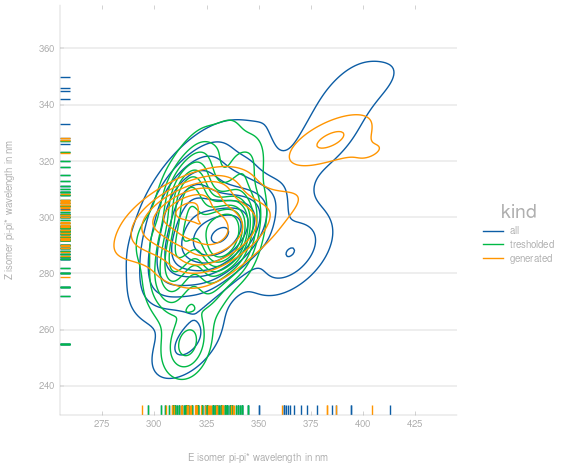

In [58]:
with plt.style.context(matplotx.styles.dufte):
    sns.displot(
        all_data,
        x="E isomer pi-pi* wavelength in nm",
        y="Z isomer pi-pi* wavelength in nm",
        kind="kde",
        hue="kind",
        rug=True,
    )

plt.savefig("extrapolation_photoswitch_dist.pdf", bbox_inches="tight")